In [85]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [86]:
news_df = pd.read_csv('/kaggle/input/dataset-news/real_or_fake_news.csv')
news_df.head()
news_df.columns = ['text', 'class'] 
print(news_df)
for i in range (0, 6075):
    if news_df['class'][i] == "REAL":
        news_df['class'][i] = 1
    if news_df['class'][i] == "FAKE":
        news_df['class'][i] = 0
news_df

                                                   text class
0     Donald Trump and Hillary Clinton, now at the s...  REAL
1     WASHINGTON -- Forty-three years after the Supr...  REAL
2     It's been a big week for abortion news.\n\nCar...  REAL
3     President Barack ObamaВ saidВ Saturday night t...  REAL
4     PLANNED PARENTHOODвЂ™S LOBBYING GETS AGGRESSIV...  REAL
...                                                 ...   ...
6070  Tuesday 1 November 2016 by Pete Redfern Micros...  FAKE
6071  US-led airstrike kills at least 30 Afghan civi...  FAKE
6072  вЂ” Kaydee King (@KaydeeKing) November 9, 2016...  FAKE
6073  Email \nThe Politico/Morning Consult Poll find...  FAKE
6074    by Jon Rappoport вЂ” Jon RappoportвЂ™s blog ...  FAKE

[6075 rows x 2 columns]


,text,class
0,"Donald Trump and Hillary Clinton, now at the s...",1
1,WASHINGTON -- Forty-three years after the Supr...,1
2,It's been a big week for abortion news.\n\nCar...,1
3,President Barack ObamaВ saidВ Saturday night t...,1
4,PLANNED PARENTHOODвЂ™S LOBBYING GETS AGGRESSIV...,1
...,...,...
6070,Tuesday 1 November 2016 by Pete Redfern Micros...,0
6071,US-led airstrike kills at least 30 Afghan civi...,0
6072,"вЂ” Kaydee King (@KaydeeKing) November 9, 2016...",0
6073,Email \nThe Politico/Morning Consult Poll find...,0


In [87]:
news_df = news_df.astype('U')
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [88]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [89]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [90]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [91]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,399,553
Trainable params: 1,399,553
Non-trainable params: 0
____________________________________________

In [101]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
print(y_train)
y_train = y_train.astype(np.float)
y_test = y_test.astype(np.float)

3821    0.0
1888    1.0
5494    0.0
2989    1.0
5880    0.0
       ... 
1726    1.0
2885    1.0
1144    1.0
4371    0.0
3370    0.0
Name: class, Length: 4860, dtype: float64


In [99]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
146/146 [==============================] - 62s 423ms/step - loss: 0.6832 - accuracy: 0.4824 - val_loss: 0.6739 - val_accuracy: 0.4712
Epoch 2/10
146/146 [==============================] - 59s 406ms/step - loss: 0.6129 - accuracy: 0.5572 - val_loss: 0.5000 - val_accuracy: 0.7963
Epoch 3/10
146/146 [==============================] - 58s 398ms/step - loss: 0.4069 - accuracy: 0.8466 - val_loss: 0.3829 - val_accuracy: 0.8251
Epoch 4/10
146/146 [==============================] - 58s 400ms/step - loss: 0.2859 - accuracy: 0.8898 - val_loss: 0.3102 - val_accuracy: 0.8210
Epoch 5/10
146/146 [==============================] - 58s 396ms/step - loss: 0.2561 - accuracy: 0.9111 - val_loss: 0.3316 - val_accuracy: 0.8786
Epoch 6/10
146/146 [==============================] - 58s 400ms/step - loss: 0.1887 - accuracy: 0.9426 - val_loss: 0.3504 - val_accuracy: 0.8786


Visualize our training over time 

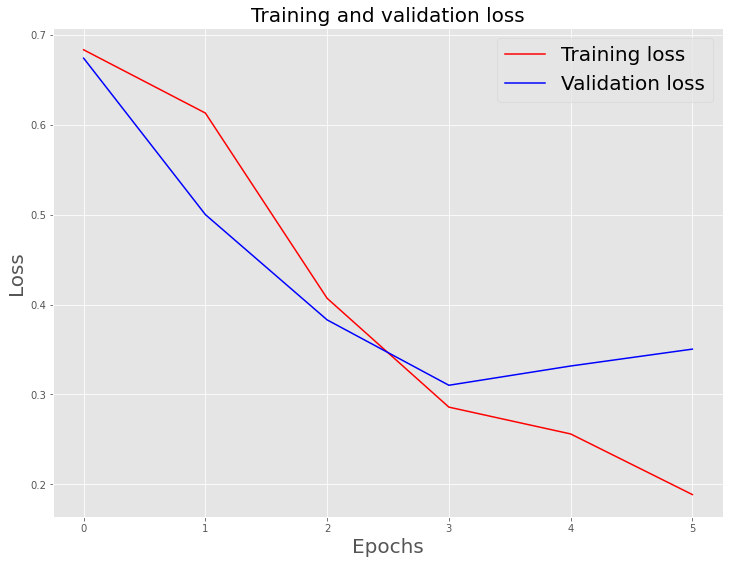

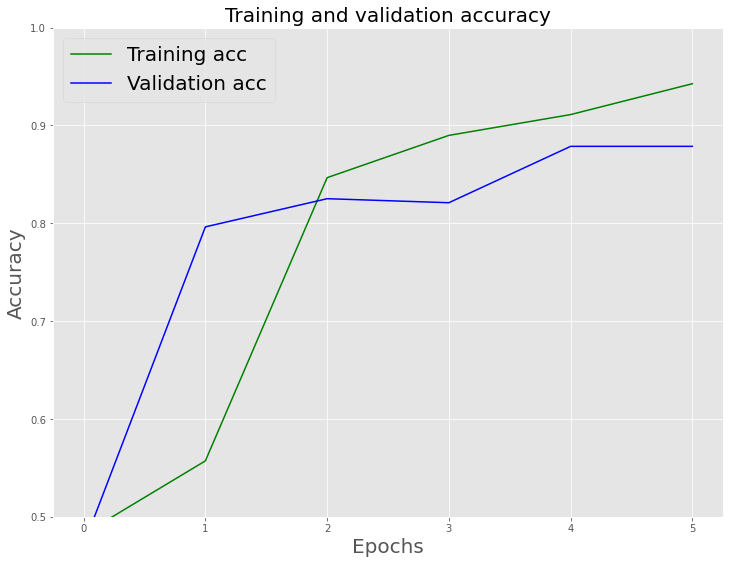

In [102]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [103]:
model.evaluate(X_test, y_test)

38/38 [==============================] - 3s 82ms/step - loss: 0.3324 - accuracy: 0.8379


[0.33243265748023987, 0.837860107421875]